## Autoencoder

An autoencoder is a neural network that is trained to perform the task of encoding and decoding an item, such that the output from this process is as close to the original item as possible.

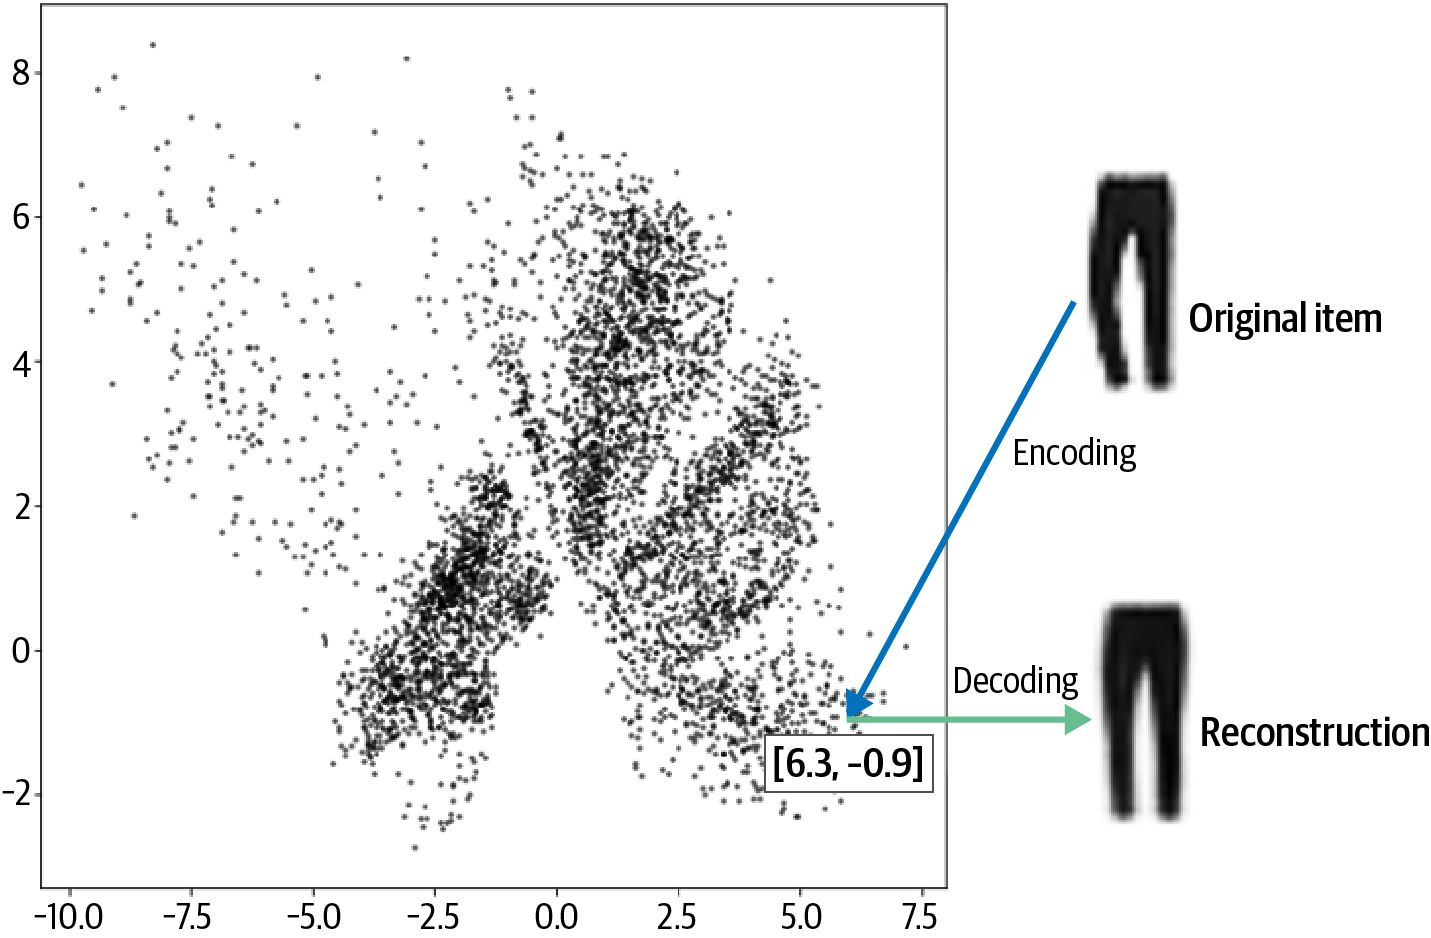

An autoencoder is a neural network made up of two parts : 

> An encoder network that compresses high-dimensional input data such as an image into a lower-dimensional embedding vector

> A decoder network that decompresses a given embedding vector back to the original domain (e.g., back to an image)

It is the **embedding space (latent space)** that is the interesting part of the autoencoder, as sampling from this space will allow us to generate new images.

The embedding (z) is a compression of the original image into a lower-dimensional latent space. 

Autoencoders can be used to clean noisy images, since the encoder learns that it is not useful to capture the position of the random noise inside the latent space in order to reconstruct the original.

When training an autoencoder on clean data, the model learns to represent the essential characteristics of the input in the latent space. However, when the autoencoder is exposed to noisy data during training, it tends to learn a representation that filters out the noise, as capturing noise is not necessary for accurately reconstructing the original input.

This ability to denoise arises because the autoencoder learns a compact representation that focuses on the essential information needed for reconstruction. If the noise in the input is random and doesn't contribute to the overall structure of the data, the autoencoder is likely to ignore it in the latent space.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
from tensorflow.keras import datasets
(x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

## Labels in FASHION MNIST Dataset

| ID | Clothing Label |
|----|-----------------|
| 0  | T-shirt/top     |
| 1  | Trouser         |
| 2  | Pullover        |
| 3  | Dress           |
| 4  | Coat            |
| 5  | Sandal          |
| 6  | Shirt           |
| 7  | Sneaker         |
| 8  | Bag             |
| 9  | Ankle boot      |


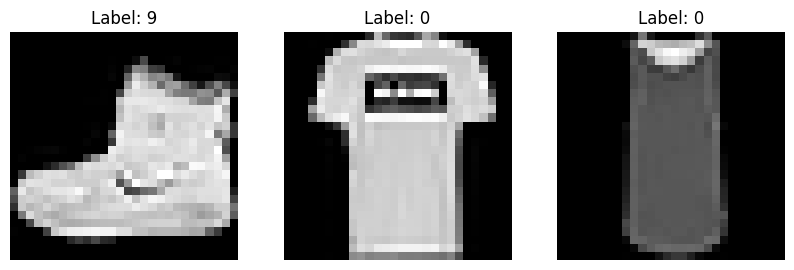

In [12]:
num_images_to_display = 3

plt.figure(figsize=(10, 4))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

In [13]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

In [14]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [15]:
from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

In [16]:
# Encoder

encoder_input = layers.Input(
     shape=(32, 32, 1), name = "encoder_input"
)

x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

In [17]:
# Decoder
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

In [18]:
autoencoder =  models.Model(encoder_input, decoder(encoder_output))
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

Binary cross-entropy loss is asymmetrical — it penalizes errors toward the extremes more heavily than errors toward the center. For example, if the true pixel value is high (say 0.7), then generating a pixel with value 0.8 is penalized more heavily than generating a pixel with value 0.6. If the true pixel value is low (say 0.3), then generating a pixel with value 0.2 is penalized more heavily than generating a pixel with value 0.4.

For RMSE means that your generated output will be symmetrically distributed around the average pixel values (because an overestimation is penalized equivalently to an underestimation).

This has the effect of binary cross-entropy loss producing slightly blurrier images than RMSE loss (as it tends to push predictions toward 0.5), 

In [19]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=5,
    batch_size=100,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/5
600/600 [==============================] - 109s 178ms/step - loss: 0.2903 - val_loss: 0.2610
Epoch 2/5
600/600 [==============================] - 106s 177ms/step - loss: 0.2576 - val_loss: 0.2569
Epoch 3/5
600/600 [==============================] - 106s 176ms/step - loss: 0.2544 - val_loss: 0.2552
Epoch 4/5
600/600 [==============================] - 105s 175ms/step - loss: 0.2523 - val_loss: 0.2527
Epoch 5/5
600/600 [==============================] - 106s 177ms/step - loss: 0.2508 - val_loss: 0.2517


In [86]:
example_images = x_test[:5000]
example_labels = y_test[:5000]
predictions = autoencoder.predict(example_images)

157/157 [==============================] - 3s 19ms/step


#### Reconstructing Images |  encoding and decoding items 

Example real clothing items


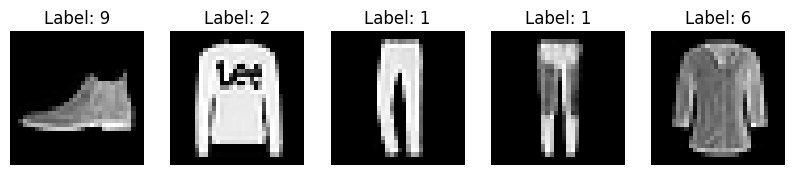

Embeddings
[[-1.6546086 -1.042184 ]]
[[ 2.78325   -4.5912967]]
[[5.5877895 2.6404598]]
[[3.3305168 1.9490101]]
[[ 1.0239996 -2.6614656]]

Reconstructions


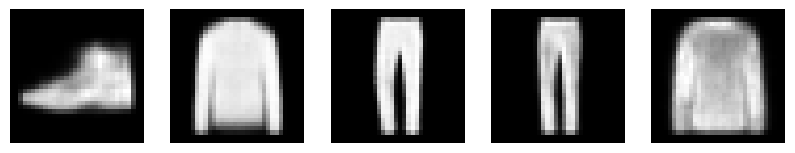

In [87]:
print("Example real clothing items")
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(example_images[i], cmap='gray')        
    plt.title(f"Label: {example_labels[i]}")
    plt.axis('off')        

plt.show()

print("Embeddings [The 2D vectors after encoding]")
for i in range(5):    
    input_image = np.expand_dims(example_images[i], axis=0)
    embeddings = encoder.predict(input_image,verbose=False)    
    print(embeddings)
print()
    
print("Reconstructions")


plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(predictions[i], cmap='gray')        
    plt.axis('off')
plt.show()    

### Visualizing the Latent Space | How images are embedded into the latent space by passing the test set through the encoder

157/157 [==============================] - 1s 4ms/step


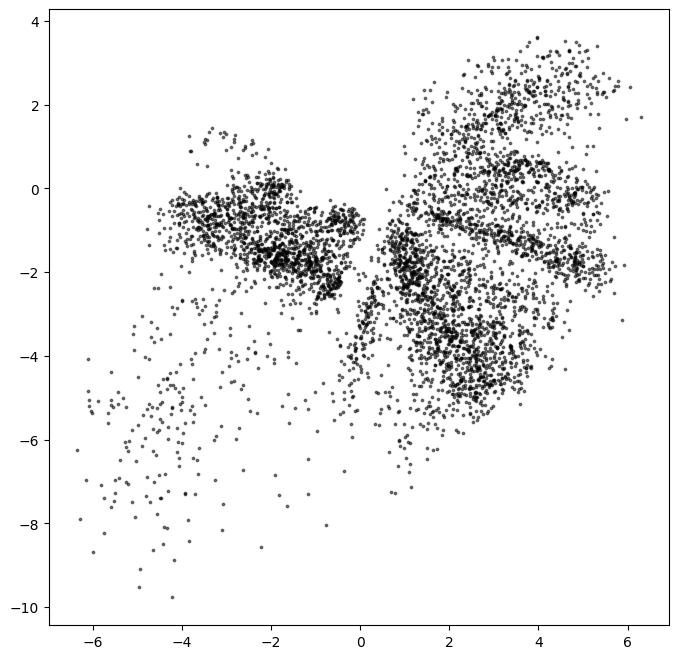

In [88]:
embeddings = encoder.predict(example_images)

plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

157/157 [==============================] - 1s 5ms/step
[[-1.6546087 -1.0421842]
 [ 2.7832506 -4.5912976]
 [ 5.587788   2.6404593]
 [ 3.3305175  1.9490095]
 [ 1.0239998 -2.6614654]
 [ 4.5654297  1.3282232]
 [ 1.1666342 -1.0962362]
 [ 1.156871  -2.0271327]
 [-2.8071496  1.2864684]
 [-3.5520642 -0.381901 ]]


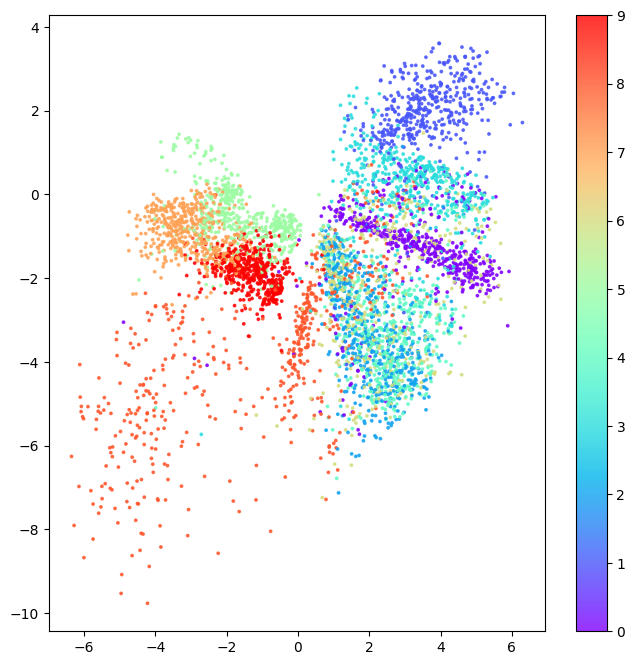

In [89]:
embeddings = encoder.predict(example_images)

# Some examples of the embeddings
print(embeddings[:10])

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

#### Generating New Images by sampling some points in the latent space and using the decoder

In [91]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, 2)
)

In [92]:
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 131ms/step


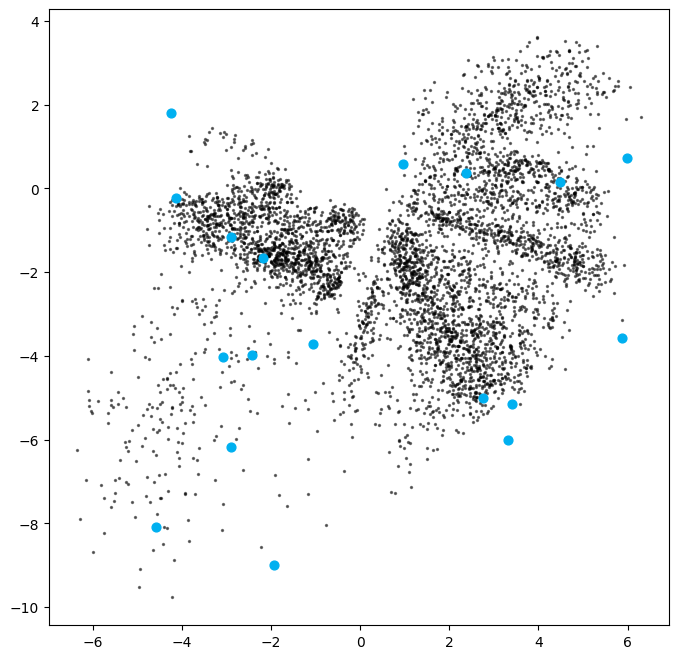

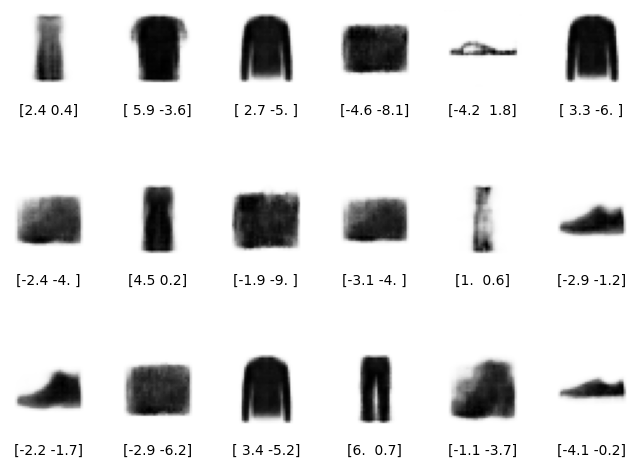

In [93]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 17ms/step


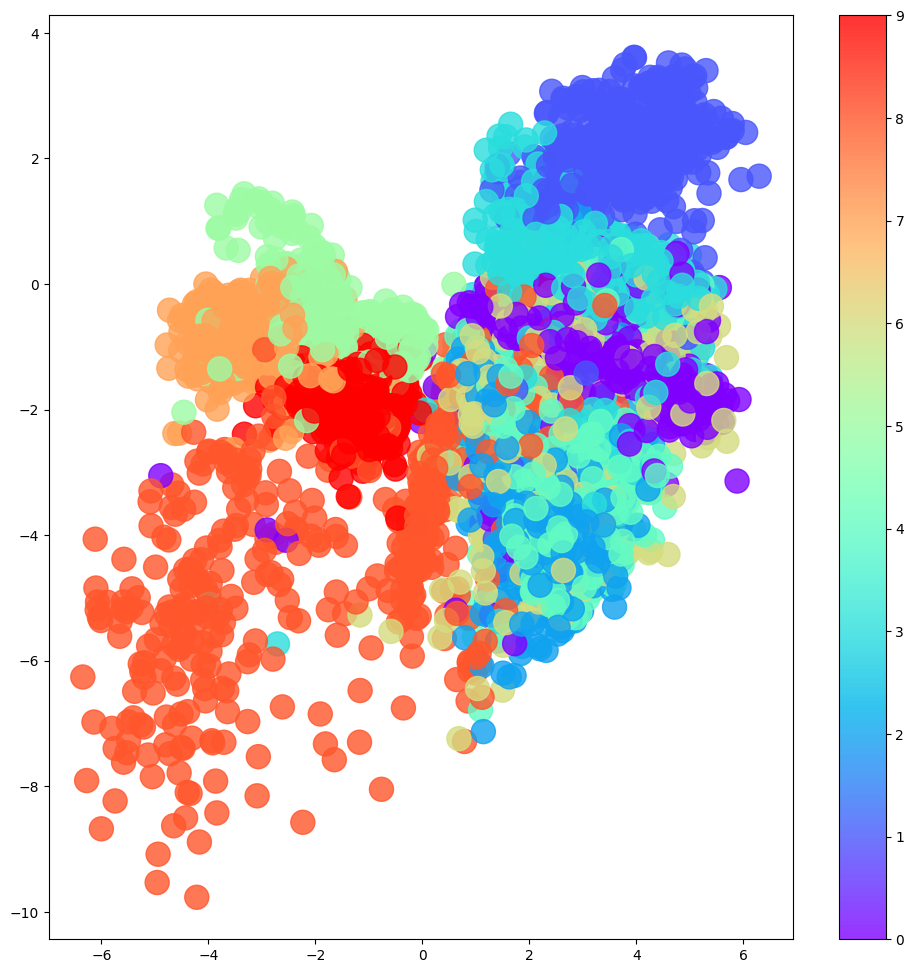

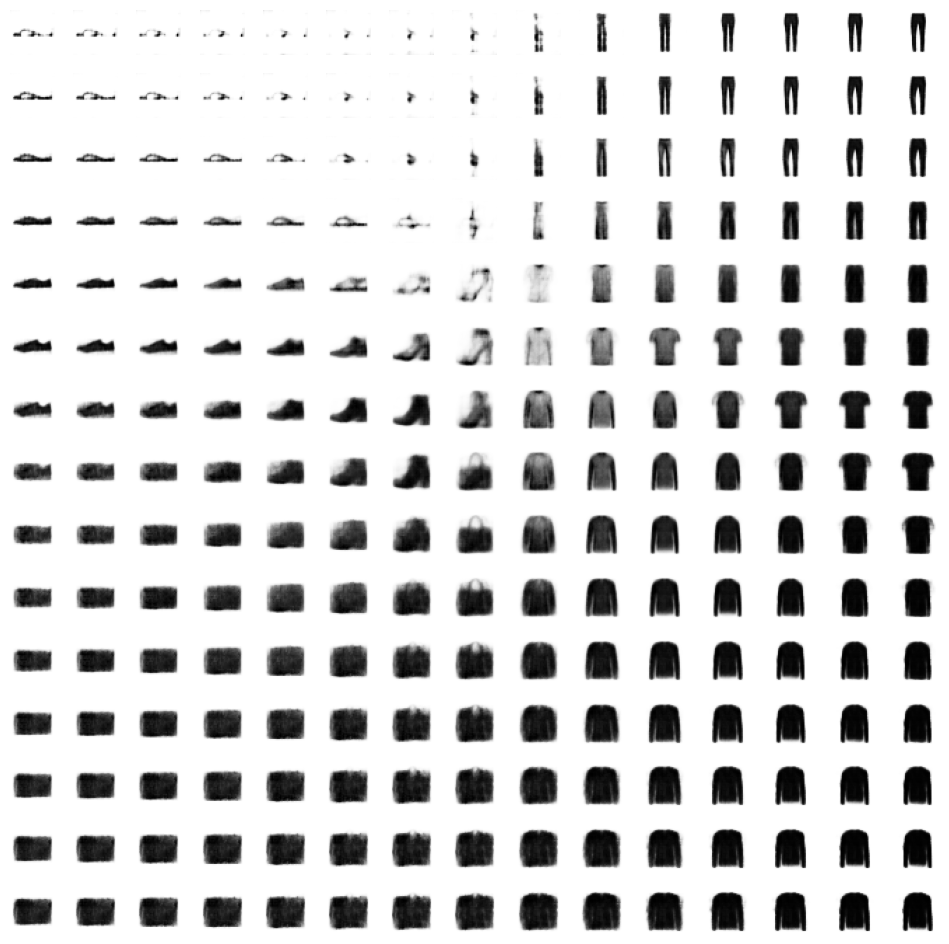

In [94]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")